In [1]:
import os
os.chdir('..')
from notebooks import config
import torch
import numpy as np
import scipy.ndimage
import random
from utils.geotif_io import readTiff, writeTiff
from utils.imgShow import imgShow,imsShow
from utils.imgPatch import imgPatch
import matplotlib.pyplot as plt
from model.seg_model.deeplabv3_plus import deeplabv3plus, deeplabv3plus_imp
from model.seg_model.model_scales_in import unet_scales
from model.seg_model.model_scales_gate import unet_scales_gate
from utils.get_s1pair_nor import get_s1pair_nor



In [2]:
# s1 scenes
scene_num = '19'
path_s1_ascend = config.dir_as + '/' + 's1_as_scene_' + scene_num +'.tif'
path_s1_descend = config.dir_des + '/' + 's1_des_scene_' + scene_num + '.tif'
path_s1_truth = config.dir_truth + '/'+ 's1_scene_' + scene_num + '_truth.tif'
s1_ascend, s1_ascend_info = readTiff(path_in=path_s1_ascend)
s1_descend, s1_descend_info = readTiff(path_in=path_s1_descend)
s1_truth, s1_truth_info = readTiff(path_in=path_s1_truth)
### get normalized s1_image
s1_img_nor = get_s1pair_nor(s1_as=s1_ascend, s1_des=s1_descend)


### Show the s1 image and the water truth

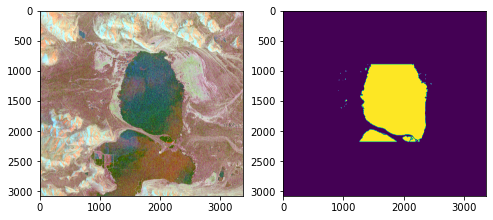

In [4]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
imgShow(s1_img_nor, color_bands=(2,1,0), clip_percent=2, per_band_clip='True')
plt.subplot(1,2,2)
imgShow(s1_truth)


In [5]:
'''Model loading'''
model_name= 'model_scales_gate'
model_weights = config.root + '/model/pretrained/'+ model_name +'_weights.pth'
# model = unet_scales(num_bands=4, num_classes=2, \
#                         scale_high=2048, scale_mid=512, scale_low=256)
model = unet_scales_gate(num_bands=4, num_classes=2, \
                            scale_high=2048, scale_mid=512, scale_low=256)
model.load_state_dict(torch.load(model_weights))
model=model.eval()


### Convert remote sensing image to multi-scale patches

In [6]:
def img2patchin(img, scales = [256, 512, 2048], overlay=60):
    ratio_mid, ratio_high = scales[1]//scales[0], scales[2]//scales[0],
    imgPat_ins = imgPatch(img=img, patch_size=scales[0], edge_overlay = overlay)
    patch_low_list = imgPat_ins.toPatch()
    patch_mid_list = imgPat_ins.higher_patch_crop(higher_patch_size=scales[1])
    patch_high_list = imgPat_ins.higher_patch_crop(higher_patch_size=scales[2])
    '''Resize multi-scale patches to the same size'''
    patch_mid2low_list = [scipy.ndimage.zoom(input=patch, zoom=(1/ratio_mid, \
                                            1/ratio_mid, 1), order=0) for patch in patch_mid_list]
    patch_high2low_list = [scipy.ndimage.zoom(input=patch, zoom=(1/ratio_high, \
                                            1/ratio_high, 1), order=0) for patch in patch_high_list]
    return patch_low_list, patch_mid2low_list, patch_high2low_list, imgPat_ins

patch_low_list, patch_mid_list, patch_high_list, imgPat_ins = img2patchin(s1_img_nor, scales = [256, 512, 2048], overlay=60)


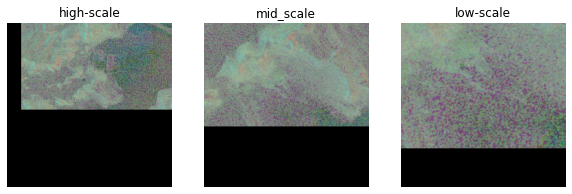

In [7]:
### check the multi-scale patches
ind =random.randrange(len(patch_low_list))
plt.figure(figsize=(10,4))
patch_list_sel = [patch_high_list[ind], patch_mid_list[ind], patch_low_list[ind]]
patch_name = ['high-scale','mid_scale','low-scale']
imsShow(img_list=patch_list_sel, img_name_list=patch_name)


In [8]:

'''----formating data: from 3d to 4d torch.tensor----'''
patch_high_list_ = [torch.from_numpy(patch.transpose(2,0,1)[np.newaxis,:]).float() \
                                                                for patch in patch_high_list]
patch_mid_list_ = [torch.from_numpy(patch.transpose(2,0,1)[np.newaxis,:]).float() \
                                                                for patch in patch_mid_list]
patch_low_list_ = [torch.from_numpy(patch.transpose(2,0,1)[np.newaxis,:]).float() \
                                                                for patch in patch_low_list]
inputs = tuple(zip(patch_high_list_, patch_mid_list_, patch_low_list_)) 

def model_pred(model, inputs):
    '''----Obtain the prediction patches----'''
    pred_patch_list = []
    for ind in range(len(inputs)):
        with torch.no_grad():
            # pred_patch = model(inputs[2])      ### for single-scale patch
            pred_patch = model(inputs[ind])           ### for multi-scale patch
            if isinstance(pred_patch, tuple):
                pred_patch = pred_patch[0]
        pred_patch_list.append(pred_patch)
    return pred_patch_list

pred_patch_list = model_pred(model, inputs)

'''----Convert the patches to image----'''
pred_patch_list = [np.squeeze(patch, axis = 0).permute(1, 2, 0) for patch in pred_patch_list]
pro_map = imgPat_ins.toImage(pred_patch_list)
cla_map = np.where(pro_map>0.5, 1, 0)



### Visualize the final classification map

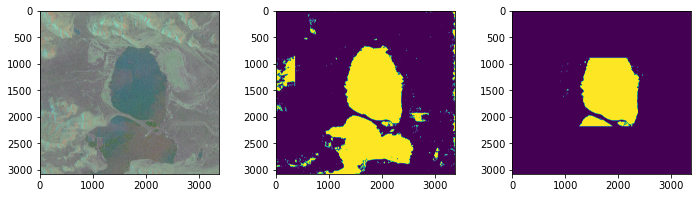

In [13]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
imgShow(s1_img_nor, clip_percent=0, color_bands=(2,1,0))
plt.subplot(1,3,2)
plt.imshow(cla_map)
plt.subplot(1,3,3)
imgShow(s1_truth)
